In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "2"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from scipy import optimize
from IPython.display import display, Math

# import sys
# sys.path.insert(0, r'/home/rk19047/PycharmProjects/MSci2022_TESS/packages')
# from unit_conversion import radius_in_stellar_radii, semi_major_axis_in_stellar_radii

In [3]:
np.random.seed(100)

In [4]:
def radius_in_stellar_radii(R_planet, R_star):
    """
    Convert planetary radius (R_Jupiter) in stellar radii.
    
    Parameters
    ----------
    R_planet : float
        Planetary radius in R_Jupiter.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    R_planet_stellar_radii : float 
        Planetary radius in stellar radii.

    """
    # 1 R_Jupiter = 0.102763 R_sun

    R_planet_stellar_radii = R_planet * 0.102763 / R_star

    return R_planet_stellar_radii

In [5]:
def semi_major_axis_in_stellar_radii(semi_major_axis, R_star):
    """
    Converting the semi-major axis (AU) to (Stellar radii)

    Parameters
    ----------
    semi_major_axis : float
        Semi-major axis of the planet in AU.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    a_stellar_radii : float
        Semi-major axis of the planet in stellar radii
    """
    #1 AU = 215.032 R_Sun

    a_stellar_radii = semi_major_axis * 215.032 / R_star #Check this

    return a_stellar_radii

In [6]:
#System
#http://exoplanets.org/detail/WASP-17b

# Semi-Major Axis[au]	0.04994 ± 0.00083
# Orbital Period[day]	3.7354330 +7.5×10-6/-7.7×10-6
# Orbital Eccentricity	0
# Orbit Inclination[deg]	86.63 +0.39/-0.45
# Argument of Periastron[deg]	90

# Time of Periastron[jd]	2454559.18096 +0.00025/-0.00021
# Transit Parameters
# Planetary Radius[rjupiter]	1.93 +0.052/-0.1
# Impact Parameter	0.400 +0.043/-0.04

# Stellar Properties
# Star Name	WASP-17
# Binary Flag	✗
# Mass of Star[msun]	1.190 ± 0.03
# Radius of Star[rsun]	1.200 +0.081/-0.08
# [Fe/H]	-0.250 ± 0.09
# Teff[k]	6550 ± 100
# Density of star[g/cm^3]	0.67 +0.16/-0.13
# log10(g)	4.20 ± 0.2
# Vsin(i)[km/s]	9.0 ± 1.5
# Gamma[km/s]	-49

In [7]:
true_R_star = 1.200 #R_sun
true_R_planet = 1.93 #R_J
true_semi_major_axis = 0.04994 #AU


params = batman.TransitParams()
params.t0 = 0.                                          #time of inferior conjunction
params.per = 3.7354330                                        #orbital period (days)
params.rp = radius_in_stellar_radii(true_R_planet, true_R_star)                #planet radius (in units of stellar radii)
params.a = semi_major_axis_in_stellar_radii(true_semi_major_axis, true_R_star) #semi-major axis (in units of stellar radii))
params.inc = 86.63                                       #orbital inclination (in degrees)
params.ecc = 0.0                                         #eccentricity
params.w = 90.                                          #longitude of periastron (in degrees)
params.limb_dark = "quadratic"                          #limb darkening model
params.u = [0.21768792859790628, 0.2836292883489928]                             #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(0, 30, 21600)                      #times at which to calculate light curve
m = batman.TransitModel(params, t)                      #initializes model
true_flux = m.light_curve(params)

In [8]:
#Add noise to the signal
sigma = 0.00001
yerrs = np.random.normal(loc=0., scale=sigma, size=len(true_flux))
true_flux += yerrs
ysigmas = np.full(len(true_flux), sigma)

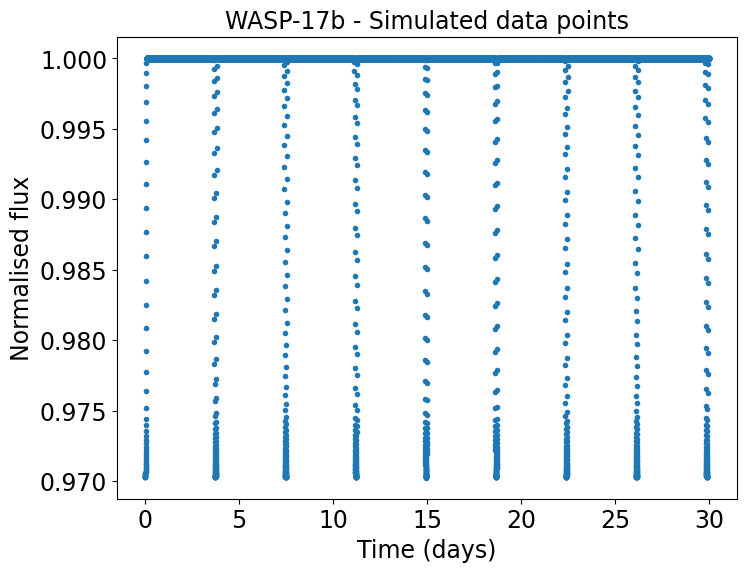

In [9]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.title("WASP-17b - Simulated data points", size=17)
plt.errorbar(t, true_flux, yerr=ysigmas, fmt='.', ecolor='LightGrey', label="Expected")
plt.xlabel("Time (days)", size=17)
plt.ylabel("Normalised flux", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)
plt.show()

In [10]:
guess_params = batman.TransitParams()
guess_params.t0 = params.t0
guess_params.per = params.per
guess_params.rp = params.rp
guess_params.a = params.a
guess_params.inc = params.inc
guess_params.ecc = params.ecc
guess_params.w = params.w
guess_params.limb_dark = "quadratic"
guess_params.u = params.u      

In [11]:
def log_likelihood(prior_params, true_flux, yerrs):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    T_0, R_planet_stellar, orbital_period, orbital_inclination, semi_major_axis, impact_parameter = prior_params

    guess_params.t0 = T_0
    guess_params.rp = R_planet_stellar
    guess_params.per = orbital_period
    guess_params.inc = orbital_inclination
    guess_params.a = semi_major_axis_in_stellar_radii(semi_major_axis, true_R_star)
    
    
    guess_m = batman.TransitModel(guess_params, t)
    guess_flux = guess_m.light_curve(guess_params)
        
    L1 = -0.5 * np.power((true_flux - guess_flux), 2) / np.power(yerrs, 2) #Sigma
    L2 = -0.5 * np.log(2 * np.pi * yerrs**2) #Sigma
    L3 = np.sum(L1) + np.sum(L2)
    return L3


def log_prior(prior_params):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    T_0, R_planet_stellar, orbital_period, orbital_inclination, semi_major_axis, impact_parameter = prior_params

    P = 0.0
    if (T_0 < 0) or (T_0 > 0.5):
        P += -np.inf
        return -np.inf

    if (R_planet_stellar < 0) or (R_planet_stellar > 0.5):
        P += -np.inf
        return P

    if (orbital_period < 0) or (orbital_period > 5):
        P += -np.inf
        return P

    if (orbital_inclination < 84) or (orbital_inclination > 90):
        P += -np.inf
        return -np.inf
    

    if (semi_major_axis < 0) or (semi_major_axis > 0.06): #AU
        P += -np.inf
        return P

    return P

def log_prob(prior_params, true_flux, yerrs):
    lp = log_prior(prior_params)
    if (np.isinf(lp) == True):
        return -np.inf

    return log_likelihood(prior_params, true_flux, yerrs) + lp

In [12]:
true_impact_parameter = np.cos(np.radians(params.inc)) * semi_major_axis_in_stellar_radii(true_semi_major_axis, true_R_star)
guess = [params.t0, params.rp, params.per, params.inc, true_semi_major_axis, true_impact_parameter]

In [13]:
pos = guess + 1E-4 * np.random.randn(20, 6)

nwalkers, ndim = pos.shape

filename = "wasp_17b.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool() as pool:
    start_time = time.time()
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(true_flux, ysigmas), a=2)
    sampler.run_mcmc(pos, 10000, progress=True)
    end_time = time.time()
    execution_time = (end_time - start_time)
    print("Start:       {}".format(time.ctime(int(start_time))))
    print("End:         {}".format(time.ctime(int(end_time))))
    print("Time taken:  {:.2f} s".format(execution_time))

  0%|          | 0/10000 [00:00<?, ?it/s]/home/rk19047/anaconda3/envs/MSci_project_solva/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [06:05<00:00, 27.37it/s]

Start:       Mon Jan  9 11:50:34 2023
End:         Mon Jan  9 11:56:40 2023
Time taken:  365.44 s


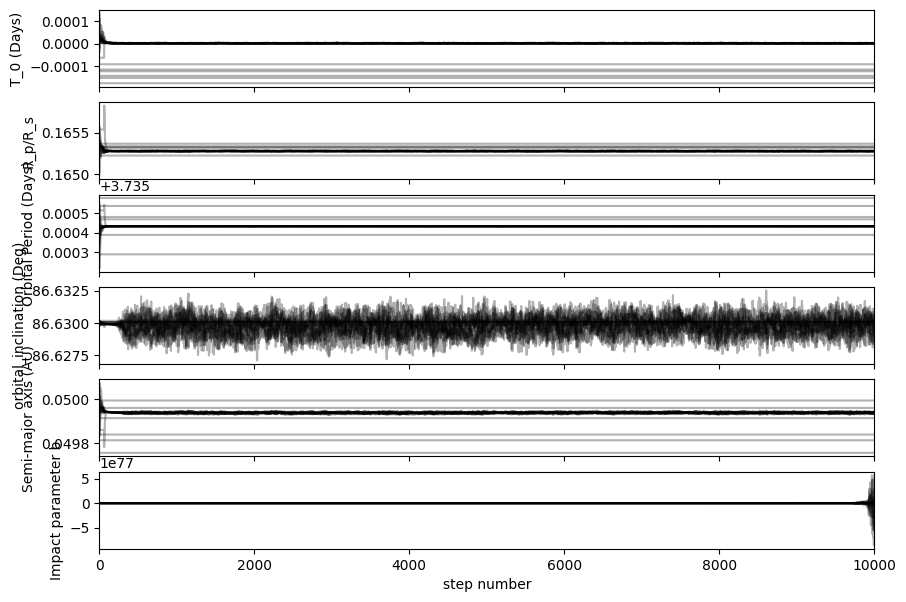

In [18]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

labels = ["T_0 (Days)", "R_p/R_s", "Orbital Period (Days)", "orbital_inclination (Deg)", "Semi-major axis (AU)", "Impact parameter b"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [19]:
tau = sampler.get_autocorr_time()
print(tau)

[nan nan  1. nan nan nan]


/home/rk19047/anaconda3/envs/MSci_project_solva/lib/python3.10/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


In [20]:
flat_samples = sampler.get_chain(discard=400, thin=15, flat=True)
print(flat_samples.shape)

(12800, 6)


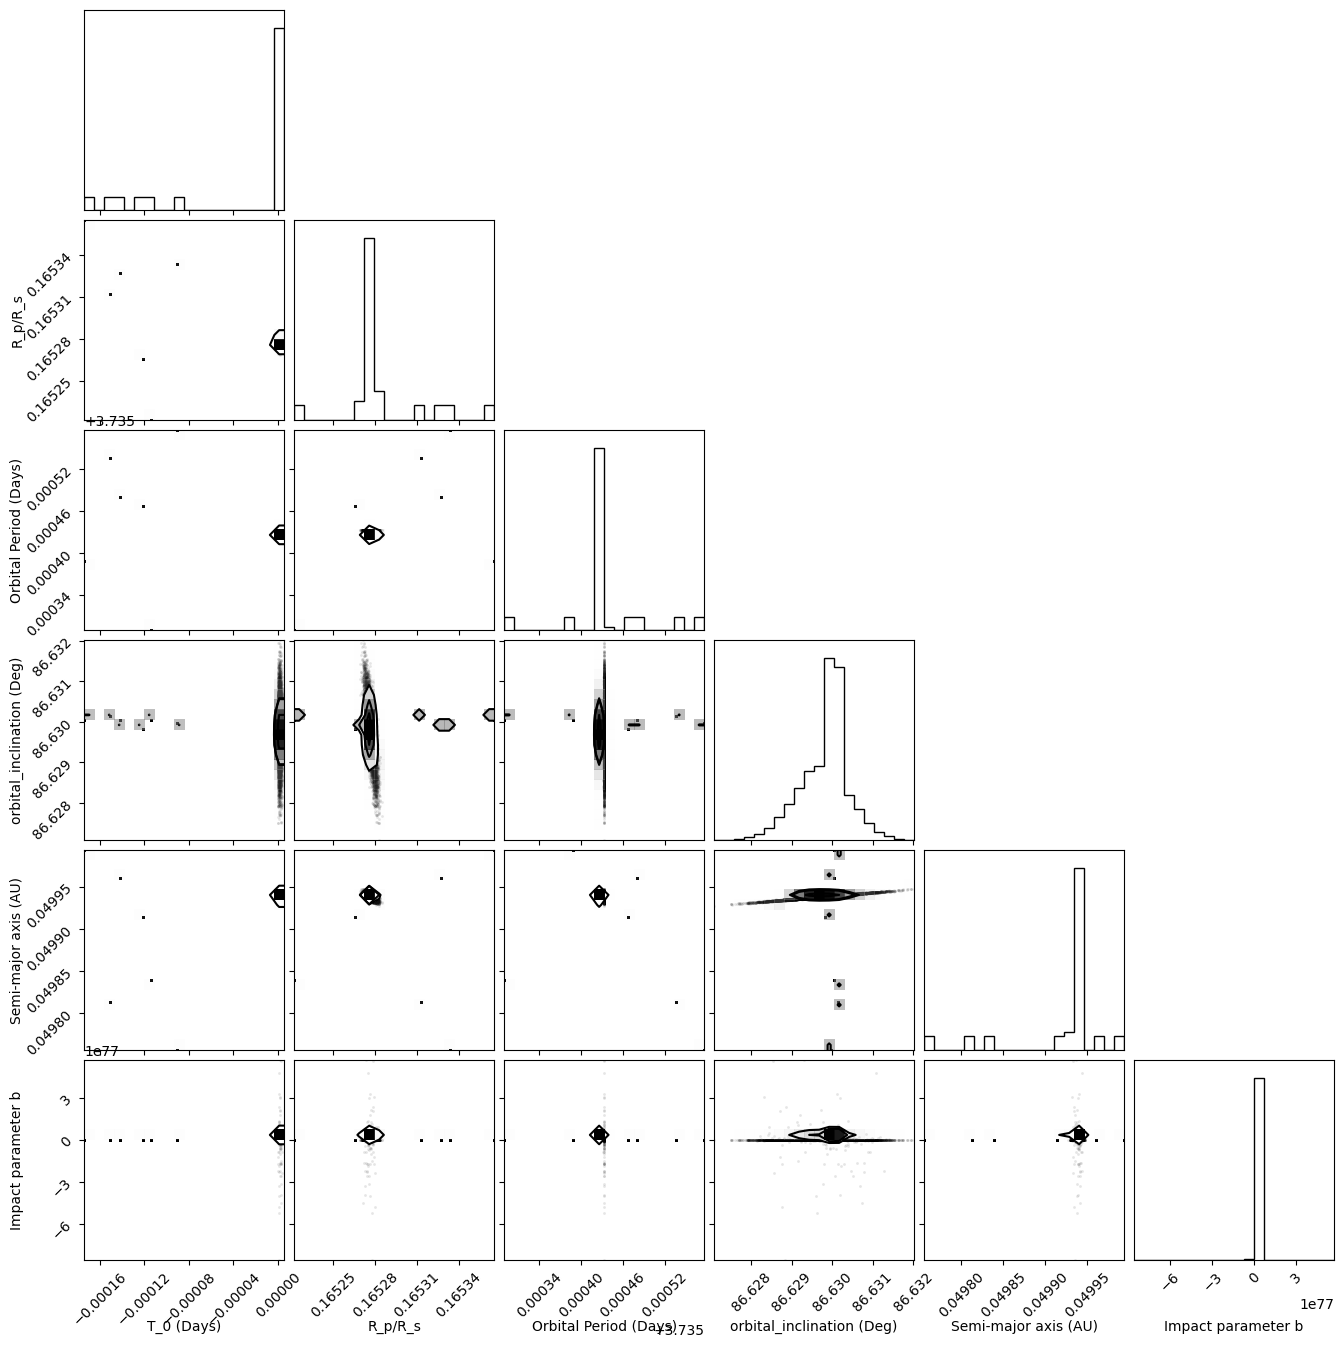

In [21]:
fig = corner.corner(
    flat_samples, labels=labels)#, truths=[params.inc, true_R_planet, true_semi_major_axis, params.per])